# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input

In [ ]:
df = pd.read_csv('/content/locomotive_data.csv')

# Data EDA (Exploratory Data Analysis)

In [ ]:
print(df.head())

                diag_trans_ts locomotive_id loco_type zone  has_ac_cab  \
0  2024-06-07 19:06:43.451753      WAP7-077      WAP7   NR           1   
1  2024-12-27 04:42:43.451753      WAP4-040      WAP4  ECR           0   
2  2023-10-06 01:12:43.451753      WAP5-060      WAP7  ECR           1   
3  2023-09-12 20:26:43.451753      WAG7-086      WAG7  ECR           0   
4  2024-07-09 05:42:43.451753     WAG9H-071      WAP4   CR           0   

       speed  temperature  vibration        load  energy_consumption  \
0  98.409797    85.660912   3.602139  105.629558          787.923212   
1  22.549538    60.944809   3.136164  110.874798         1154.603160   
2  46.936859    57.203280   1.485721   67.429760         1107.879091   
3  71.402630    58.977165   3.890576   47.697138          880.743130   
4  87.931286    74.986759   2.457389   20.427897         1059.764944   

   wheel_wear  brake_pressure  battery_voltage        mileage   humidity  \
0    8.580449        4.272105        26.306771

In [ ]:
print(df.shape)

(10000, 19)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   diag_trans_ts                 10000 non-null  object 
 1   locomotive_id                 10000 non-null  object 
 2   loco_type                     10000 non-null  object 
 3   zone                          10000 non-null  object 
 4   has_ac_cab                    10000 non-null  int64  
 5   speed                         10000 non-null  float64
 6   temperature                   10000 non-null  float64
 7   vibration                     10000 non-null  float64
 8   load                          10000 non-null  float64
 9   energy_consumption            10000 non-null  float64
 10  wheel_wear                    10000 non-null  float64
 11  brake_pressure                10000 non-null  float64
 12  battery_voltage               10000 non-null  float64
 13  mi

In [ ]:
df.isnull().sum()

,0
diag_trans_ts,0
locomotive_id,0
loco_type,0
zone,0
has_ac_cab,0
speed,0
temperature,0
vibration,0
load,0
energy_consumption,0


In [ ]:
target = 'fault_label'
if target in df.columns:
    print(f"Class Distribution in Target ({target}):")
    print(df[target].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=target)
    plt.title("Class Distribution")
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


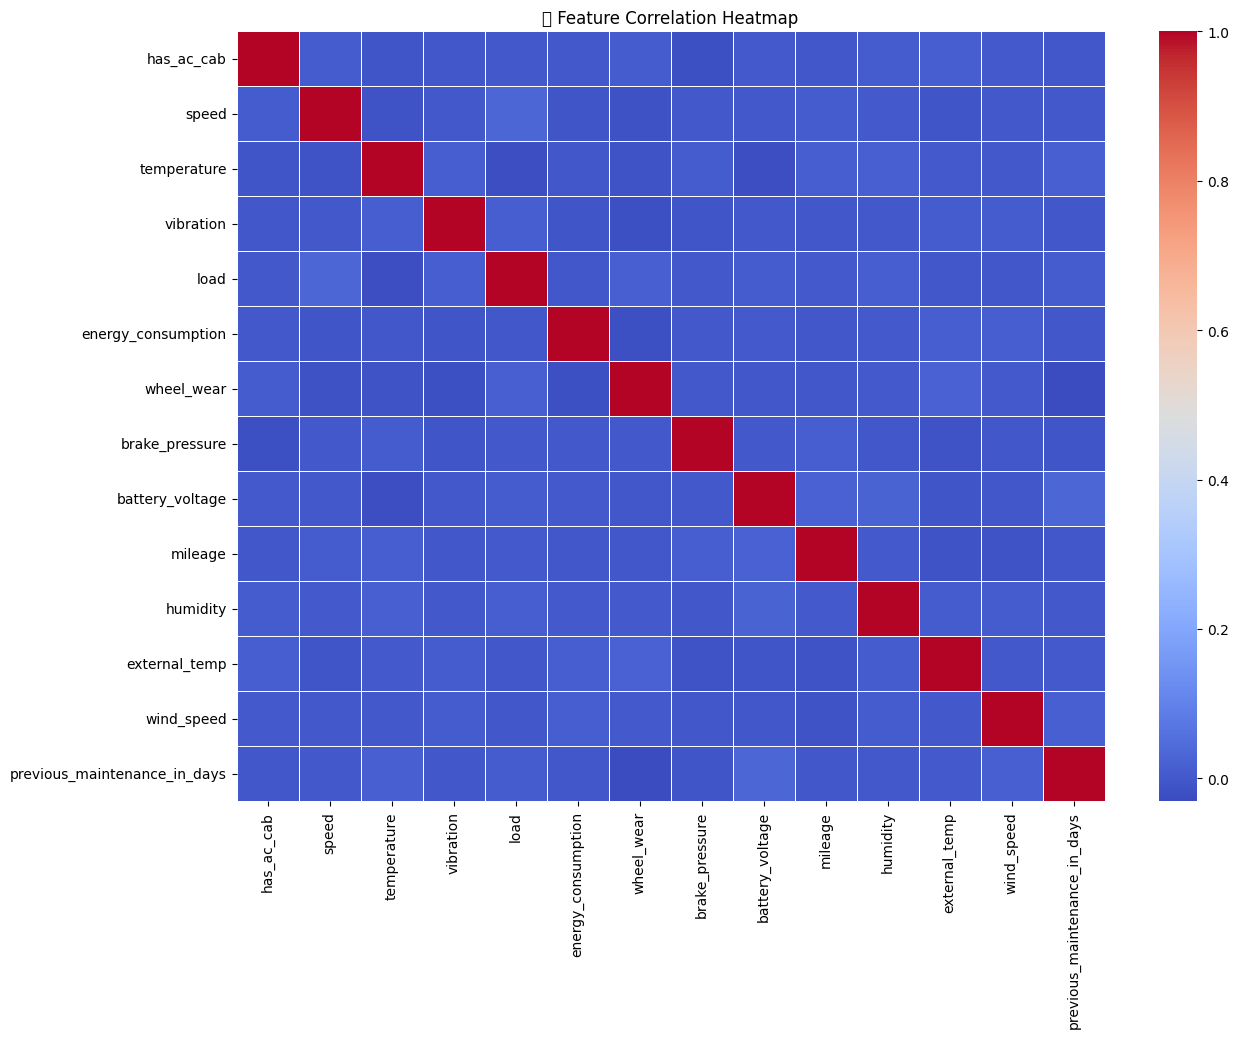

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(14, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

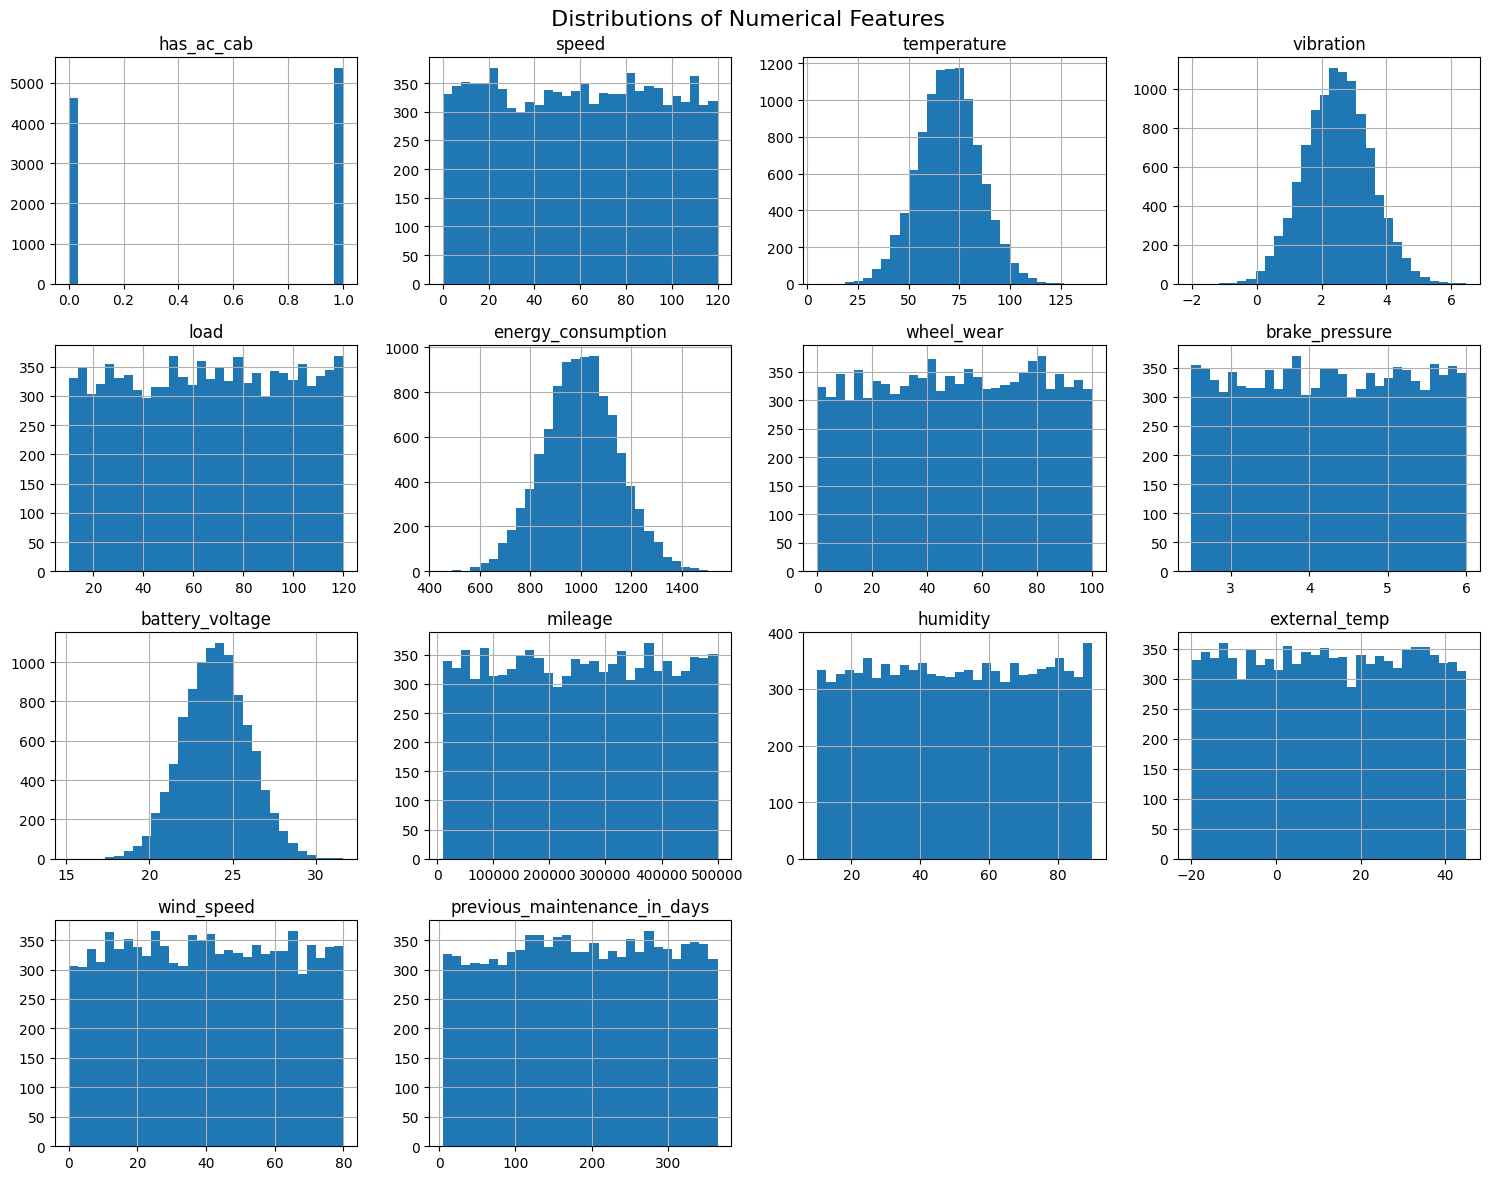

In [ ]:
df[numeric_cols].hist(figsize=(15, 12), bins=30)
plt.suptitle(" Distributions of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

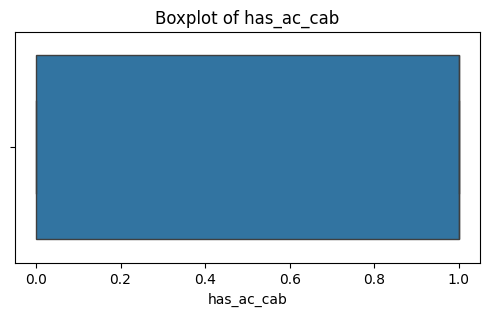

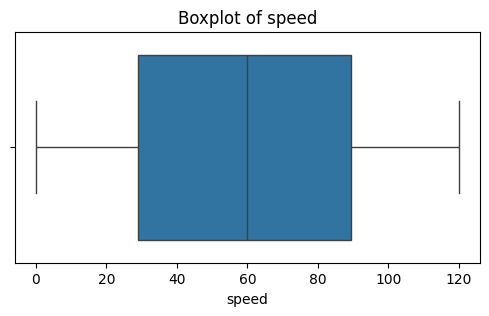

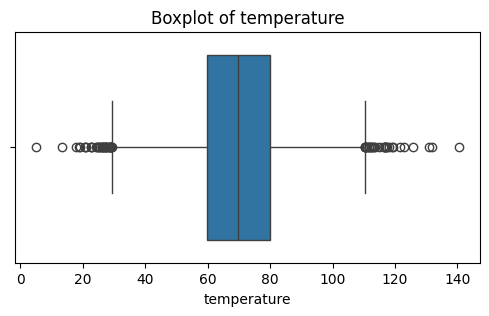

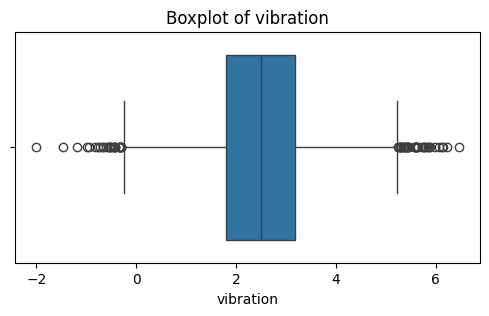

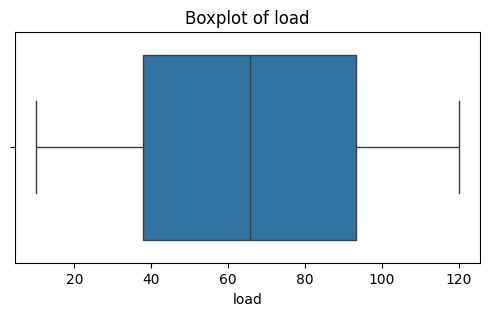

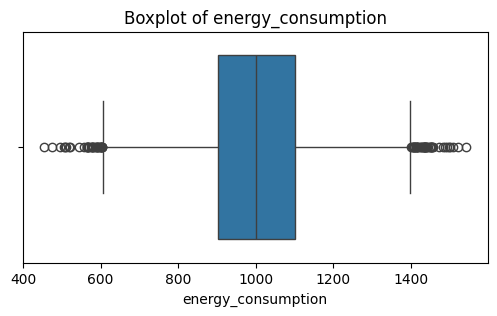

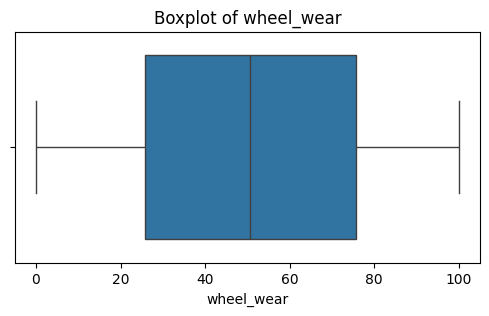

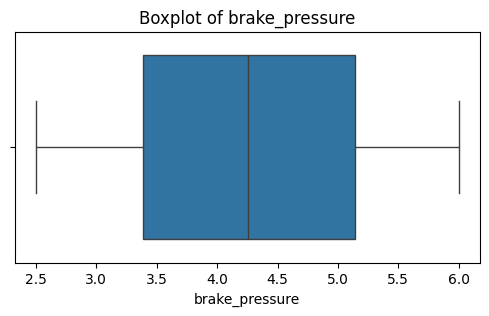

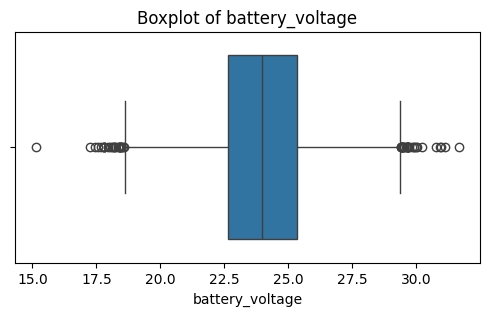

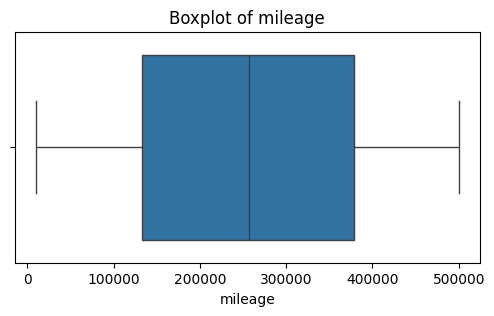

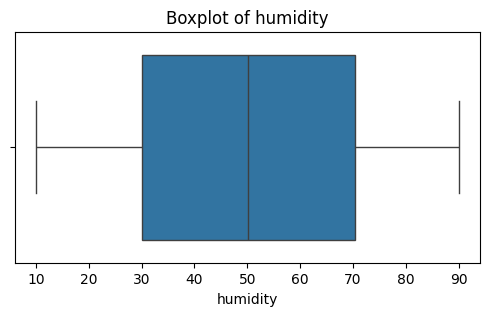

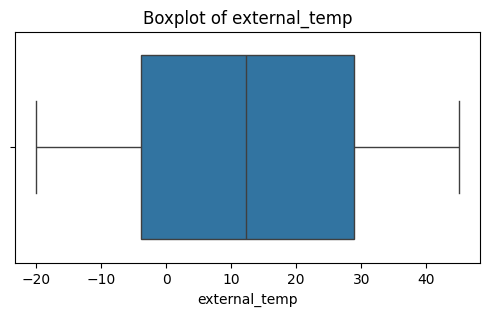

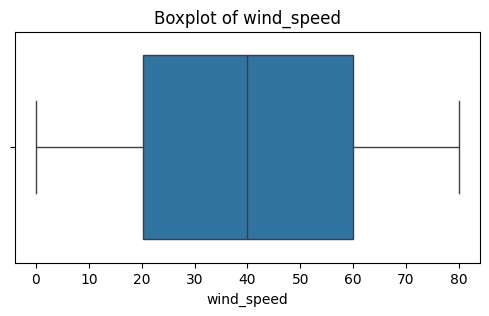

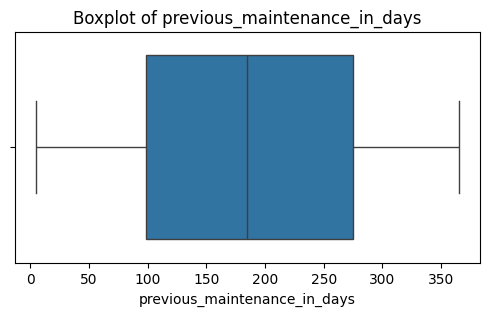

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

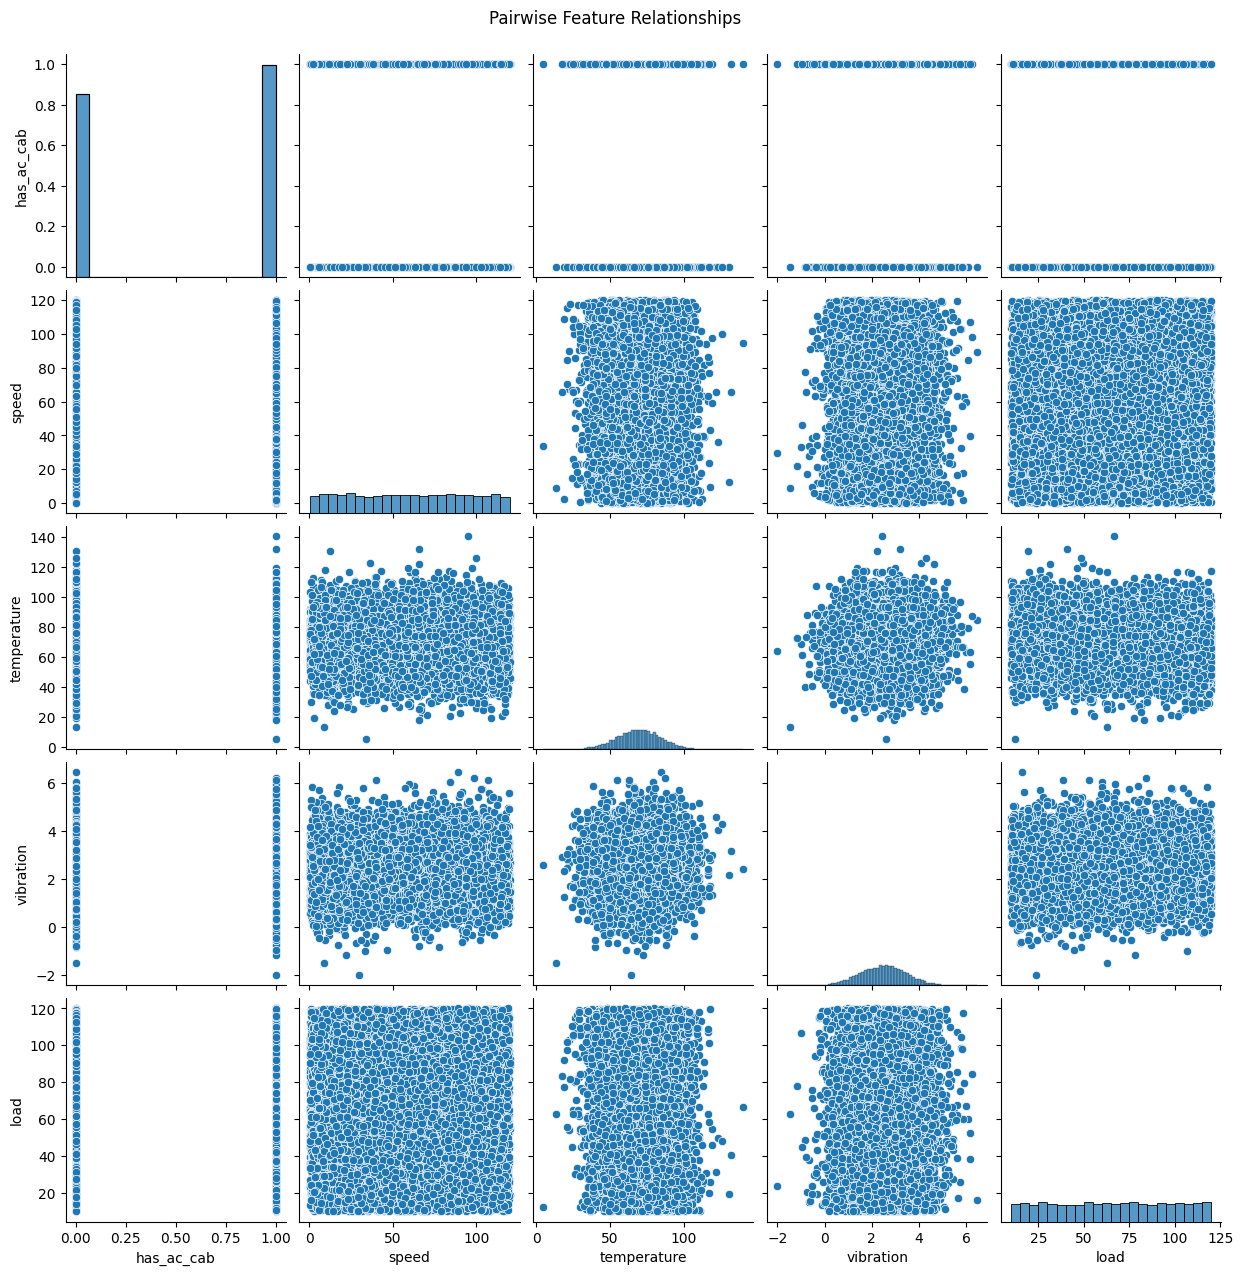

In [ ]:
selected_cols = numeric_cols[:5] + [target] if target in df.columns else numeric_cols[:5]
sns.pairplot(df[selected_cols], hue=target if target in df.columns else None)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# Train

In [ ]:
df = df.dropna()
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
fault_code_cols = [col for col in df.columns if col.startswith('fault_code_')]
target = fault_code_cols
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
y_encoded = y.idxmax(axis=1)
le = LabelEncoder()
y_encoded = le.fit_transform(y_encoded)
print("Classes:", le.classes_)

Classes: ['fault_code_Excessive Wheel Wear' 'fault_code_Low Battery'
 'fault_code_Normal' 'fault_code_Overheating']


Testing 25%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Evaluation:
Accuracy: 0.6708
Precision (macro): 0.48206417552206887
Recall (macro): 0.27955972935991835

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.03      0.05       434
           1       0.00      0.00      0.00        43
           2       0.67      0.99      0.80      1643
           3       0.95      0.10      0.19       380

    accuracy                           0.67      2500
   macro avg       0.48      0.28      0.26      2500
weighted avg       0.64      0.67      0.56      2500



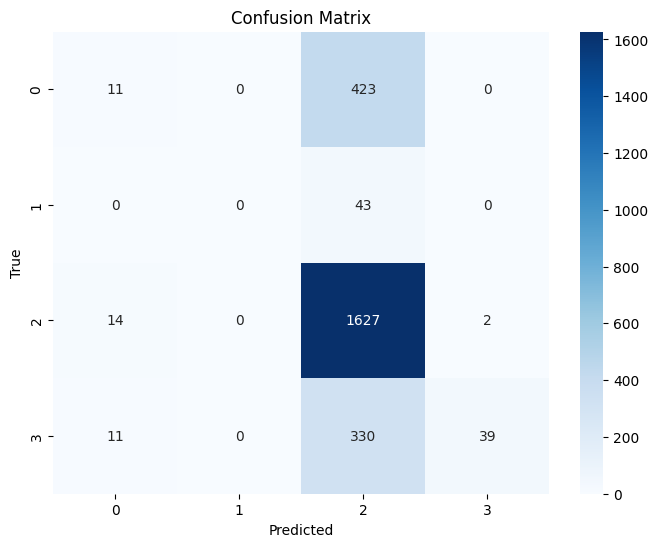

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

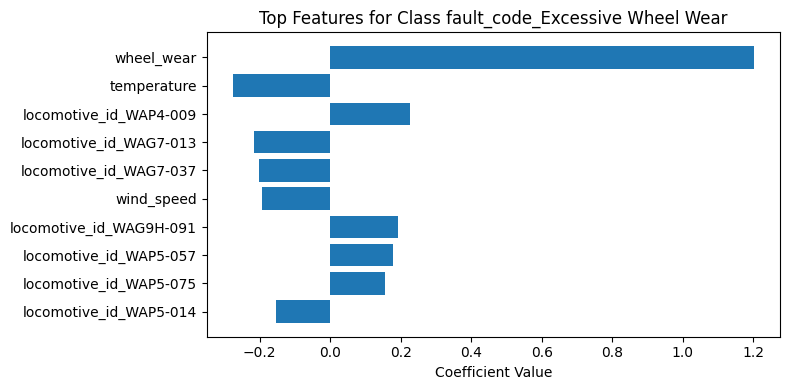

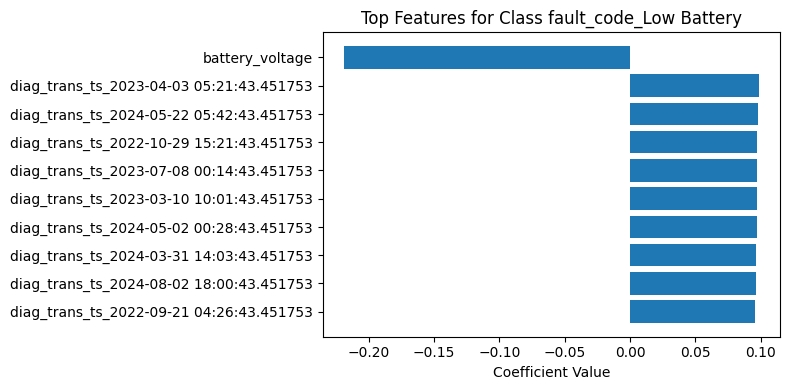

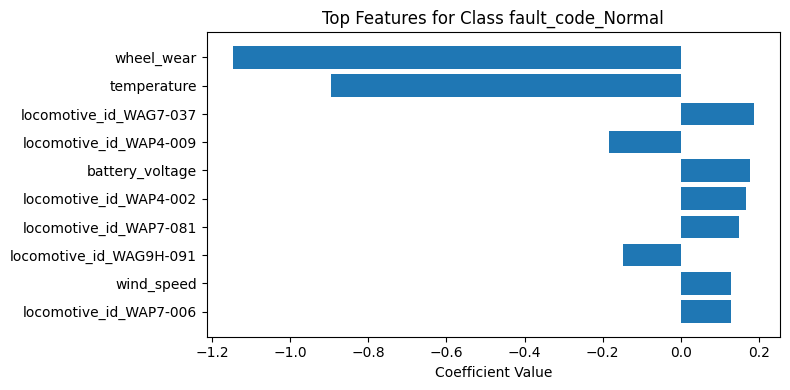

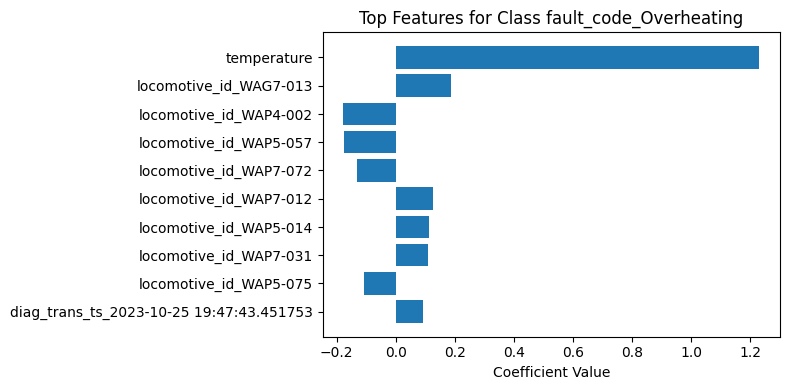

In [ ]:
coef = logreg.coef_
feature_names = X.columns

for i, class_label in enumerate(np.unique(y_encoded)):
    coef_class = coef[i]
    top_features_idx = np.argsort(np.abs(coef_class))[-10:]  # Top 10
    plt.figure(figsize=(8, 4))
    plt.barh(range(10), coef_class[top_features_idx], align='center')
    plt.yticks(range(10), [feature_names[j] for j in top_features_idx])
    plt.title(f"Top Features for Class {le.classes_[i]}")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

# Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

In [ ]:
def evaluate(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
evaluate(y_test, y_pred_dt, "Decision Tree")


--- Decision Tree ---
Accuracy: 0.9992
Precision: 0.9996960486322188
Recall: 0.9883720930232558
Confusion Matrix:
 [[ 434    0    0    0]
 [   0   41    2    0]
 [   0    0 1643    0]
 [   0    0    0  380]]


In [ ]:
if 'le' in globals():
    class_names = le.classes_
else:
    class_names = np.unique(y_test)

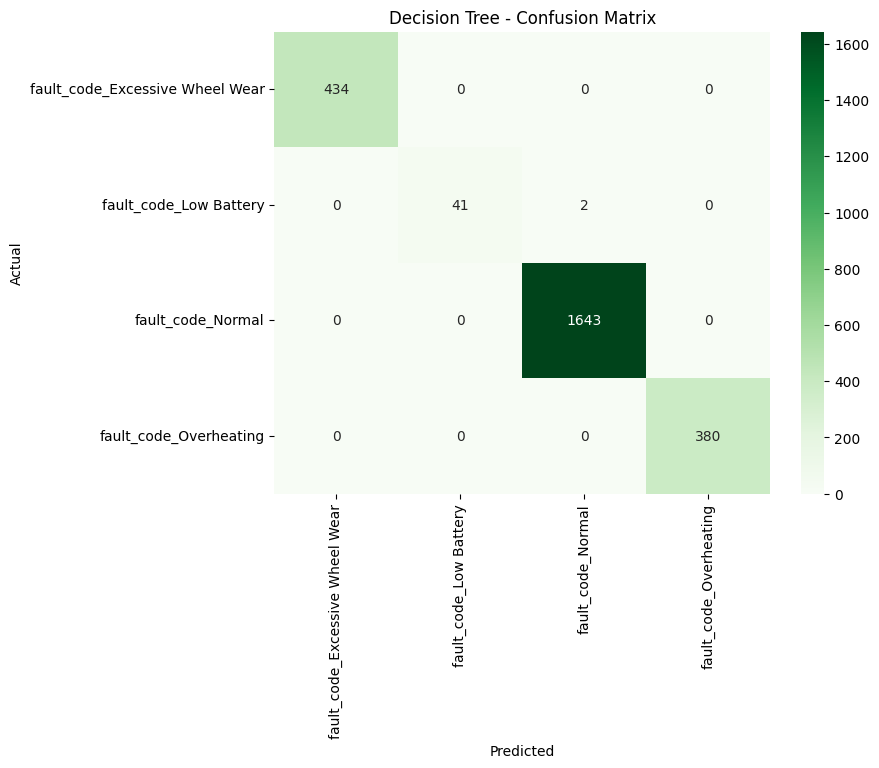

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [ ]:
def evaluate(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
evaluate(y_test, y_pred_rf, "Random Forest")


--- Random Forest ---
Accuracy: 0.6572
Precision: 0.1643
Recall: 0.25
Confusion Matrix:
 [[   0    0  434    0]
 [   0    0   43    0]
 [   0    0 1643    0]
 [   0    0  380    0]]


In [ ]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

/tmp/ipython-input-29-2863752611.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


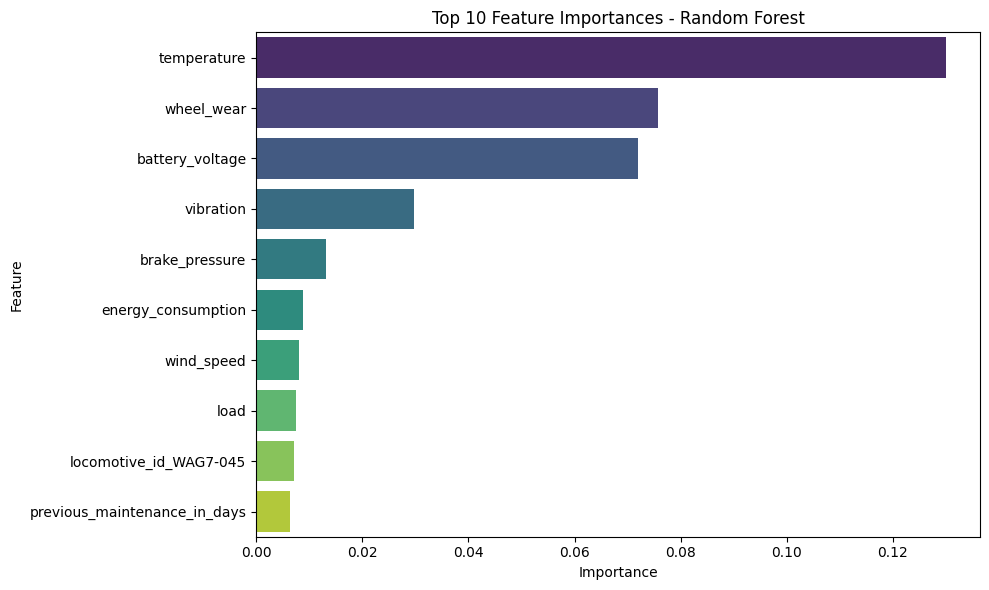

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

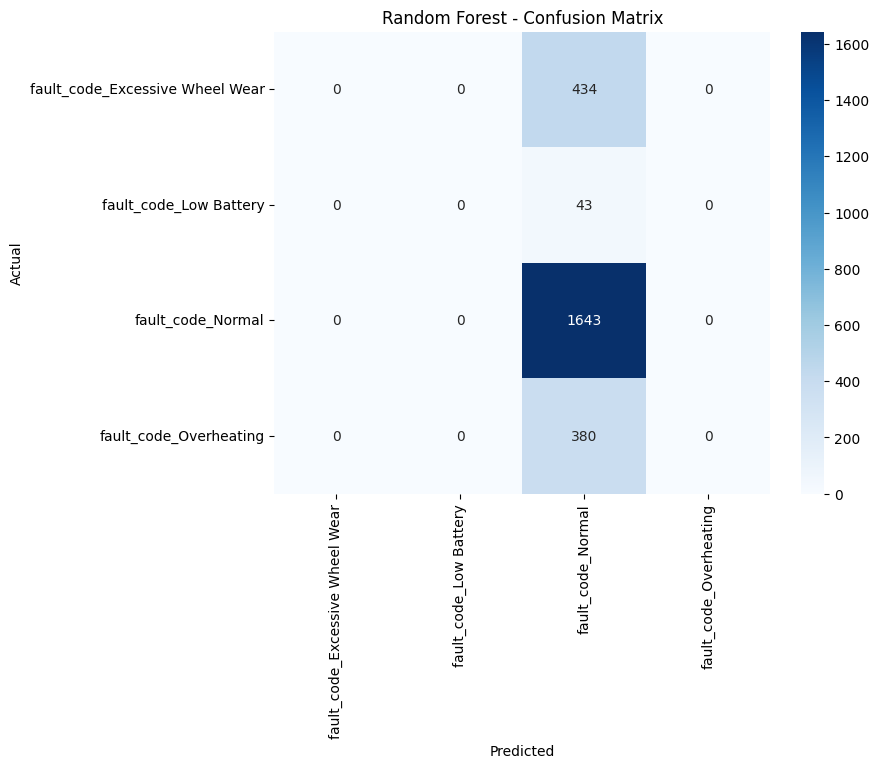

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest with tuned hyperparameters

In [ ]:
rf_tuned = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_tuned.fit(X_train_scaled, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

In [ ]:
evaluate(y_test, y_pred_rf_tuned, "Random Forest (Tuned)")


--- Random Forest (Tuned) ---
Accuracy: 0.6572
Precision: 0.1643
Recall: 0.25
Confusion Matrix:
 [[   0    0  434    0]
 [   0    0   43    0]
 [   0    0 1643    0]
 [   0    0  380    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Deep Neural Network

In [ ]:
model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])
model_dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_dnn.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

dnn_eval = model_dnn.evaluate(X_test_scaled, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6251 - loss: 1.0141 - val_accuracy: 0.6620 - val_loss: 0.8425
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9445 - loss: 0.2356 - val_accuracy: 0.6013 - val_loss: 0.9443
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9925 - loss: 0.0269 - val_accuracy: 0.6027 - val_loss: 0.9690
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9976 - loss: 0.0109 - val_accuracy: 0.5840 - val_loss: 1.0045
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.5807 - val_loss: 1.0237
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.5727 - val_loss: 1.0468
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.5673 - val_loss: 1.0650
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 7.2297e-04 - val_

In [ ]:
evaluate(y_test, y_pred_rf, "Deep Neural Network")


--- Deep Neural Network ---
Accuracy: 0.6572
Precision: 0.1643
Recall: 0.25
Confusion Matrix:
 [[   0    0  434    0]
 [   0    0   43    0]
 [   0    0 1643    0]
 [   0    0  380    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# LSTM (Time Series)

In [ ]:
timesteps = 5
def create_sequences(X, y, timesteps=5):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i+timesteps)])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_train_scaled, y_train, timesteps)
X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test, timesteps)

model_lstm = Sequential([
    LSTM(64, input_shape=(timesteps, X.shape[1])),
    Dense(len(np.unique(y_encoded)), activation='softmax')])
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_seq, y_seq, epochs=10, batch_size=32, validation_split=0.2)
lstm_eval = model_lstm.evaluate(X_seq_test, y_seq_test)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - accuracy: 0.3443 - loss: 1.4246 - val_accuracy: 0.1508 - val_loss: 2.1473
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.7696 - loss: 0.5598 - val_accuracy: 0.0320 - val_loss: 1.7639
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.9929 - loss: 0.0899 - val_accuracy: 0.0520 - val_loss: 1.6500
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 173ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.0400 - val_loss: 1.5227
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.0427 - val_loss: 1.4835
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.0447 - val_loss: 1.4633
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.0520 - val_loss: 1.4501
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 1.0000 - loss: 0

In [ ]:
# Generate predictions from the LSTM model
y_pred_lstm = model_lstm.predict(X_seq_test)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

evaluate(y_seq_test, y_pred_lstm_classes, "LSTM")

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step

--- LSTM ---
Accuracy: 0.6569138276553106
Precision: 0.1643602085840353
Recall: 0.24969530773918341
Confusion Matrix:
 [[   0    0  434    0]
 [   0    0   42    0]
 [   1    0 1639    1]
 [   0    0  378    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Autoencoder

In [ ]:
normal_data = X_train_scaled[y_train == 0]
input_dim = normal_data.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(normal_data, normal_data, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7567 - val_loss: 0.7539
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7515 - val_loss: 0.7537
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7499 - val_loss: 0.7538
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.7445 - val_loss: 0.7540
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.7375 - val_loss: 0.7542
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7381 - val_loss: 0.7542
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7344 - val_loss: 0.7543
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7361 - val_loss: 0.7544
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7358 - val_loss: 0.7544
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7332 - val_loss: 0.7544
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7343 - val_loss: 0.7545
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7

# Reconstruction Error

In [ ]:
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
pred_anomaly = (mse > threshold).astype(int)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
print("Autoencoder Anomaly Detection Accuracy:", accuracy_score((y_test != 0).astype(int), pred_anomaly))

Autoencoder Anomaly Detection Accuracy: 0.2068


# XGBoost


--- XGBoost ---
Accuracy: 0.9968
Precision: 0.9907438654850349
Recall: 0.9813734599418048
Confusion Matrix:
 [[ 433    0    1    0]
 [   2   40    1    0]
 [   3    1 1639    0]
 [   0    0    0  380]]


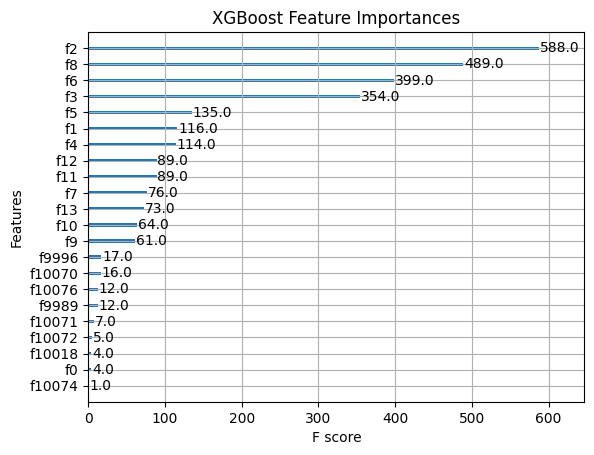

In [ ]:
model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)
evaluate(y_test, y_pred_xgb, "XGBoost")

xgb.plot_importance(model_xgb)
plt.title("XGBoost Feature Importances")
plt.show()

# Voting Classifier (Ensemble)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500)),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ],
    voting='soft')
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
evaluate(y_test, y_pred_voting, "Voting Classifier")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Voting Classifier ---
Accuracy: 0.9944
Precision: 0.9970218100127466
Recall: 0.9552700675168793
Confusion Matrix:
 [[ 427    0    7    0]
 [   2   36    5    0]
 [   0    0 1643    0]
 [   0    0    0  380]]
